In [1]:
# Import dependencies
import matplotlib
matplotlib.use('nbagg')
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt

# Python SQL toolkit and ORM
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, desc

# Additional dependencies
import pandas as pd
import numpy as np
import csv
import os
import seaborn as sns
from datetime import datetime as dt, timedelta


# Step 3 - Climate Analysis and Exploration

In [2]:
# Create engine to a SQLite database
engine = create_engine("sqlite:///hawaii.sqlite", echo = False)

In [3]:
# Get tables in the Hawaii Database
inspector = inspect(engine)
inspector.get_table_names()

['measurements', 'stations']

In [4]:
# Get list of column names and types for Measurements Table
columns = inspector.get_columns('measurements')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [5]:
# Get list of column names and types for Stations Table
columns = inspector.get_columns('stations')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [6]:
# Reflect Database into ORM classes
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys() # Retrieve the names of the tables in the database

['measurements', 'stations']

In [7]:
Measurements = Base.classes.measurements # Map measurements class
Stations = Base.classes.stations # Map stations class

In [8]:
session = Session(engine)

# Precipitation Analysis

In [9]:
# Design a query to retrieve the last 12 months of precipitation data.
# Select only the date and prcp values.
# Load the query results into a Pandas DataFrame and set the index to the date column.
# Plot the results using the DataFrame plot method.

In [10]:
# Retrieve Latest Date - This way we do not have to 'hardcode the date' later in our code...
session.query(Measurements.date).order_by(Measurements.date.desc()).first()

('2017-08-23')

In [11]:
# Retrieve the first [0] record and store it in the latest date variable
latest_date = session.query(Measurements.date).order_by(Measurements.date.desc()).first()[0]
# Use strptime function to store the formatted date in the format_latest_date variable. We will use this in our code later
format_latest_date = dt.strptime(latest_date,"%Y-%m-%d")
format_latest_date # Display the date

datetime.datetime(2017, 8, 23, 0, 0)

In [12]:
# Query for retrieving last 12 months of precipitation data
# All precipitation data for last 12 months
sel = [Measurements.date, Measurements.prcp]
initial_date = format_latest_date - timedelta(days=365) # This will be start date from 12 months before final date of 8/23/17
prcp_data = session.query(*sel).\
    filter((Measurements.date >= initial_date)).all()
    
prcp_data[:10] # Display the records

[('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0)]

In [13]:
# Create the Dataframe for storing the SQL query results for last 12 months of preceipitation data
prcp_df = pd.DataFrame(prcp_data, columns=['Precipitation Date', 'Precipitation'])
prcp_df.set_index('Precipitation Date', inplace=True) # Set the index by date

In [14]:
# Get the count of total number of records in the dataframe
prcp_df.count()

Precipitation    2015
dtype: int64

In [15]:
prcp_df.head() 

,Precipitation
Precipitation Date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


# Precipitation Analysis Plot

<IPython.core.display.Javascript object>


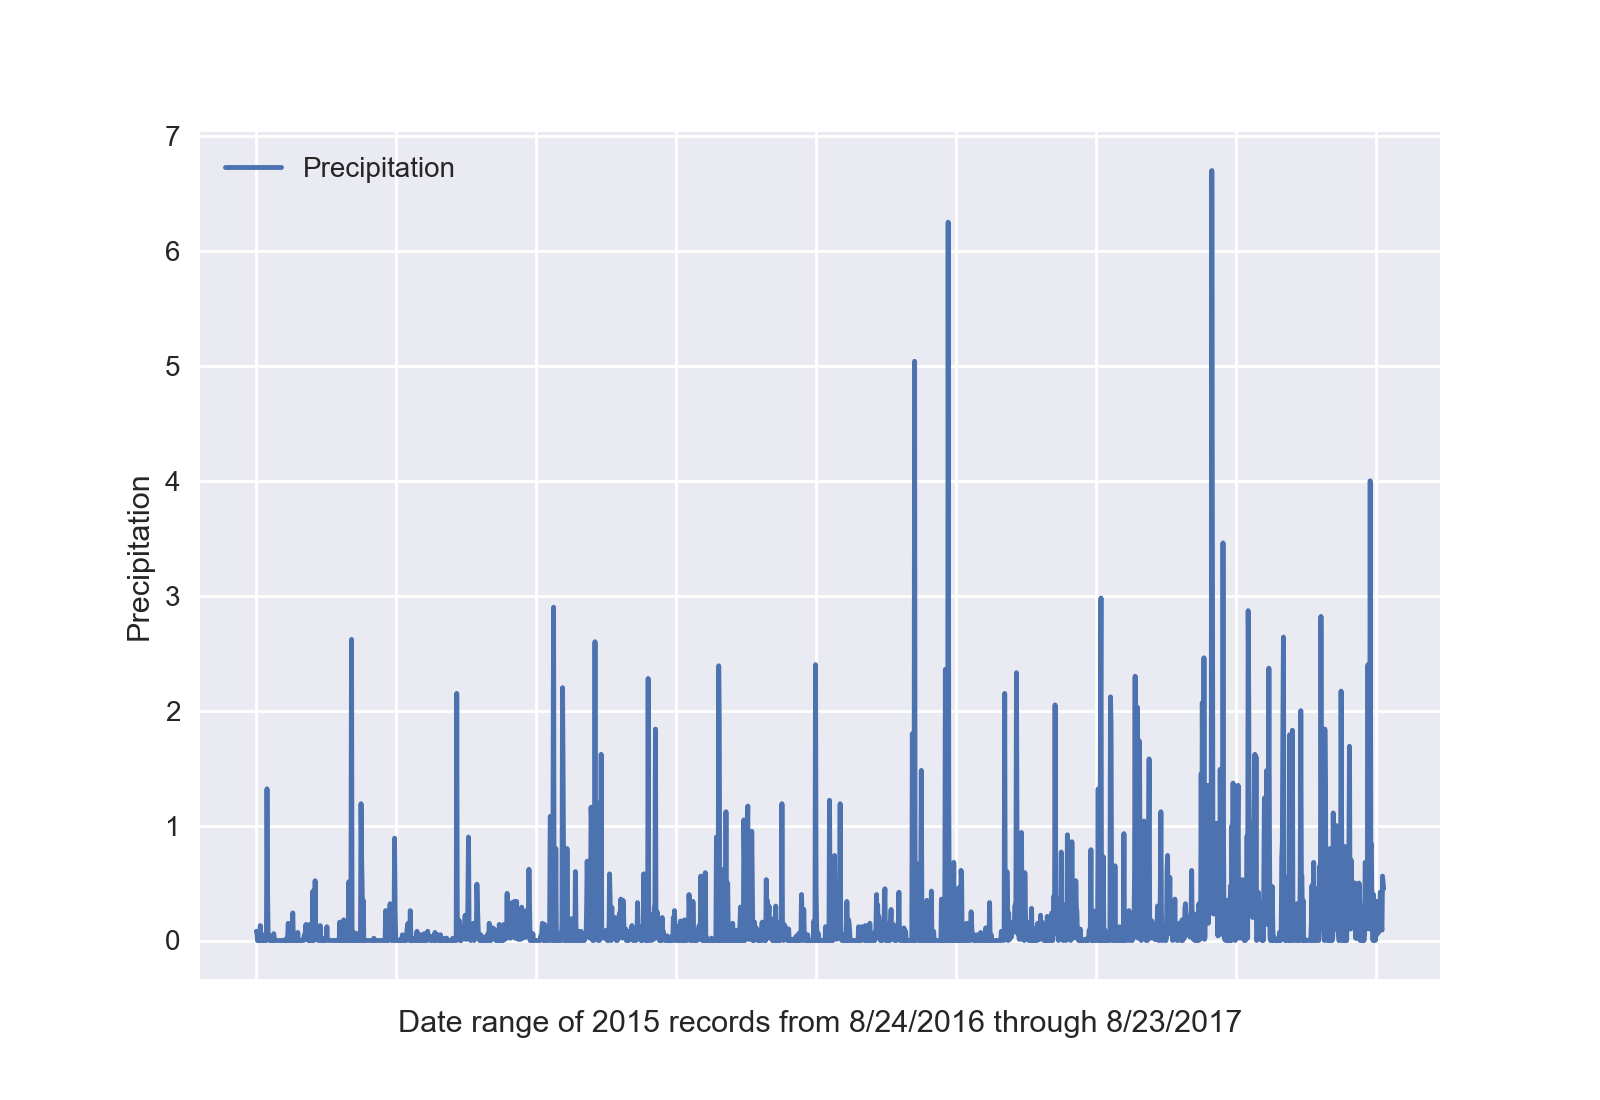

In [16]:
# Create the plot
prcp_df.plot()
plt.xlabel("Date range of 2015 records from 8/24/2016 through 8/23/2017")
plt.ylabel("Precipitation")
plt.show()

# New plot with Average precipitation data for each day - just to give a new view
# We will get total of 365 prcp records (each record is average) from 8/24/2016 through 8/23/2017

In [17]:
# Design a NEW query to retrieve the last 12 months of AVERAGE precipitation data for each day.
sel = [Measurements.date, func.avg(Measurements.prcp)]
initial_date = format_latest_date - timedelta(days=365) # This will be start date from 12 months before final date of 8/23/17
prcp_data = session.query(*sel).filter((Measurements.date >= initial_date)).group_by(Measurements.date).order_by(Measurements.date).all()

In [18]:
# Create the Dataframe for storing the SQL query results for last 12 months of preceipitation data
prcp_1_df = pd.DataFrame(prcp_data, columns=['Precipitation Date', 'Precipitation'])
prcp_1_df.set_index('Precipitation Date', inplace=True) # Set the index by date
# Get the count of total number of records in the dataframe
prcp_1_df.count()

Precipitation    365
dtype: int64

In [19]:
prcp_1_df.head() # Display the top 5 records of the dataframe

,Precipitation
Precipitation Date,
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667


<IPython.core.display.Javascript object>


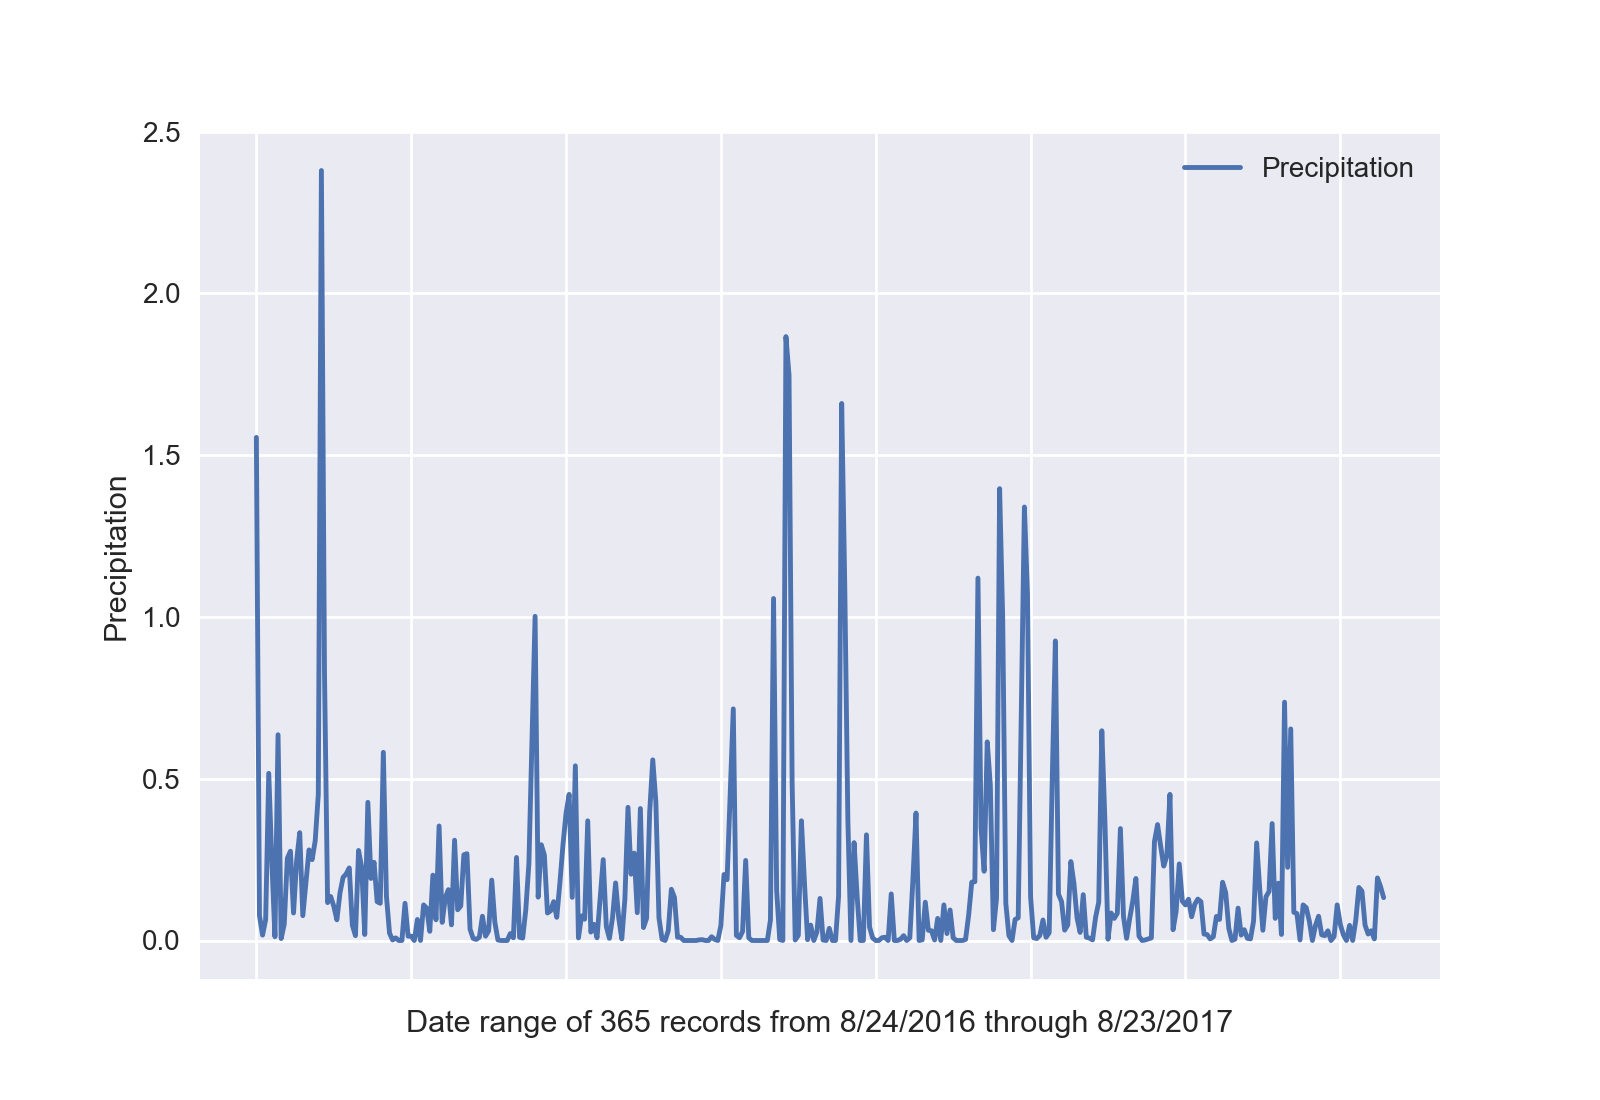

In [20]:
# Create the plot
prcp_1_df.plot()
plt.xlabel("Date range of 365 records from 8/24/2016 through 8/23/2017")
plt.ylabel("Precipitation")
plt.show()

# Summary Statistics for Precipitation Data

In [21]:
#Use Pandas to print the summary statistics for the precipitation data.
prcp_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [22]:
prcp_df.dtypes

Precipitation    float64
dtype: object

# Station Analysis

In [23]:
# Station Analysis


# Design a query to calculate the total number of stations.
# Design a query to find the most active stations.
    # List the stations and observation counts in descending order
    # Which station has the highest number of observations?
# Design a query to retrieve the last 12 months of temperature observation data (tobs).
    # Filter by the station with the highest number of observations.
    # Plot the results as a histogram with bins=12.

# Station Names and Station IDs

In [24]:
# Return a json list of stations from the dataset - This code is for our climate app for flask part of our homework
# We will create a JSON response via converting our SQL query to Dataframe first, and then to a dictionary
stations = session.query(Stations.name, Stations.station).all()
stations_df  = pd.DataFrame(stations,columns=["Station Name", "Station ID"])
stations_dict = stations_df.to_dict(orient='records')
stations_dict #Display the dictionary response of all the stations name and their respective station IDs.

[{'Station ID': 'USC00519397', 'Station Name': 'WAIKIKI 717.2, HI US'},
 {'Station ID': 'USC00513117', 'Station Name': 'KANEOHE 838.1, HI US'},
 {'Station ID': 'USC00514830',
  'Station Name': 'KUALOA RANCH HEADQUARTERS 886.9, HI US'},
 {'Station ID': 'USC00517948', 'Station Name': 'PEARL CITY, HI US'},
 {'Station ID': 'USC00518838', 'Station Name': 'UPPER WAHIAWA 874.3, HI US'},
 {'Station ID': 'USC00519523',
  'Station Name': 'WAIMANALO EXPERIMENTAL FARM, HI US'},
 {'Station ID': 'USC00519281', 'Station Name': 'WAIHEE 837.5, HI US'},
 {'Station ID': 'USC00511918',
  'Station Name': 'HONOLULU OBSERVATORY 702.2, HI US'},
 {'Station ID': 'USC00516128', 'Station Name': 'MANOA LYON ARBO 785.2, HI US'}]

# Total Number of Stations

In [25]:
# Design a query to calculate the total number of stations.
station_count = session.query(Stations.id).count()
print ("Total Number of Stations are: "+ str(station_count))

Total Number of Stations are: 9


# Most Active Stations

In [26]:
# Design a query to find the most active stations.
    # List the stations and observation counts in descending order
    # Which station has the highest number of observations?
# Query for finding the most active stations
# List the stations and observation counts in descending order
sel = [Measurements.station, func.count(Measurements.tobs)]
active_stations_data = session.query(*sel).group_by(Measurements.station).order_by(desc(func.count(Measurements.tobs))).all()
active_stations_data

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [27]:
print ("The station with the highest number of observations is: " + str(active_stations_data[0]))

The station with the highest number of observations is: ('USC00519281', 2772)


In [28]:
highest_station = active_stations_data[0][0] #Storing the highest station as a variable
# This is needed for our plot below

# Last 12 months of tobs for the station with highest number of obeservations

In [29]:
# Design a query to retrieve the last 12 months of temperature observation data (tobs).
# Filter by the station with the highest number of observations.
# Plot the results as a histogram with bins=12.

sel = [Measurements.tobs]
temperature_data = session.query(*sel).\
    filter(Measurements.date >= initial_date).\
    filter(Measurements.station == highest_station).all()

# Note-> initial_date was calcuated as 8/23/2016 by us earlier
# Note -> highest_station was calculated by us earlier

In [30]:
len(temperature_data) #Capturing the length of our query result (dataset)

351

In [31]:
# print (temperature_data) # printing the query results
# Commented this print code out as it was just for understanding the layout of temperature_data, which we will create into a list below

# Plot the results as a histogram with bins=12.

In [32]:
# Creating a list of items 'tobs_data' from our initial mulitdimensional array 'temperature_data'
tobs_data = []
for row in temperature_data:
    tobs_data.append(row[0])
# tobs_data
# Again, commented the tobs_data print as it was just needed to understand the layout

<IPython.core.display.Javascript object>


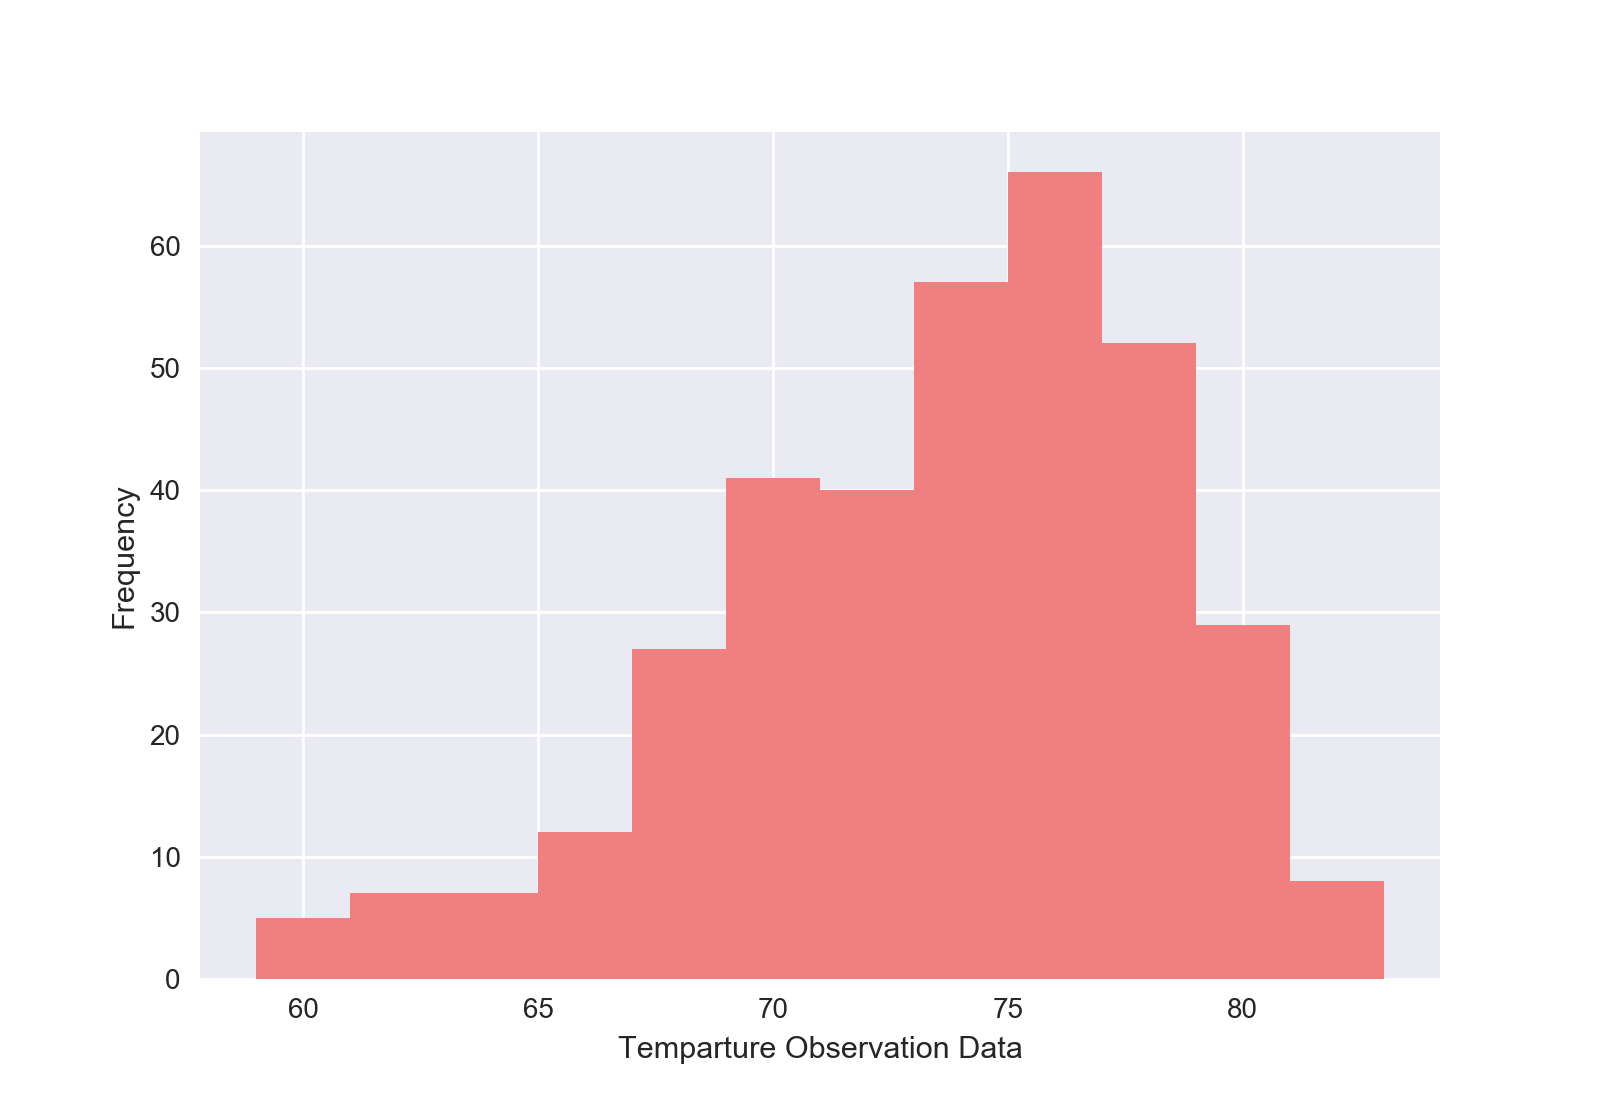

In [33]:
plt.hist(tobs_data, bins=12, label='tobs', color = 'lightcoral')
plt.xlabel("Temparture Observation Data")
plt.ylabel("Frequency")
plt.show()

# Code for Temperature Analysis

In [34]:
#Temperature Analysis
#Write a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d and return the minimum, average, and maximum temperatures for that range of dates.
#Use the calc_temps function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")
#Plot the min, avg, and max temperature from your previous query as a bar chart.
#Use the average temperature as the bar height.
#Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

In [35]:
def calc_temp(start_date, end_date):
    Start_Date = dt.strptime(start_date, "%Y-%m-%d")
    Start_Date = Start_Date.replace(Start_Date.year - 1)
    End_Date = dt.strptime(end_date, "%Y-%m-%d")
    End_Date = End_Date.replace(End_Date.year - 1)
    
    #Collect all the dates between start date and end date
    delta = End_Date - Start_Date
    date_range = []
    for i in range(delta.days + 1):
        date_range.append(Start_Date + timedelta(days=i))
       
    #Converting to stings
    str_date_range = []
    for date in date_range:
        new_date = date.strftime("%Y-%m-%d")
        str_date_range.append(new_date)
       
   #Calculate Average Tempareure , Min and Maximum temperatures within the date range    
    temp_avg = session.query(func.avg(Measurements.tobs))\
              .filter(Measurements.date.in_(str_date_range))[0][0]
    temp_min = session.query(func.min(Measurements.tobs))\
              .filter(Measurements.date.in_(str_date_range))[0][0]
    temp_max = session.query(func.max(Measurements.tobs))\
              .filter(Measurements.date.in_(str_date_range))[0][0]
       
    return temp_avg, temp_min, temp_max

    

# Prompt the user to enter the start and end dates of the trip, and then call the function to display results

In [36]:
# Prompt the user to enter the start and end dates for the trip
start_date = input("Please enter your trip's start date in yyyy-mm-dd format: ")
end_date = input ("Please enter your trip's end date in yyyy-mm-dd format: ")

Please enter your trip's start date in yyyy-mm-dd format: 2017-08-01
Please enter your trip's end date in yyyy-mm-dd format: 2017-08-20


In [37]:
Trip_Output = calc_temp(start_date, end_date)
print ("Your average temperature, minimum temperature and maximum temperature respectively for your drip durations are: " + str(Trip_Output))

Your average temperature, minimum temperature and maximum temperature respectively for your drip durations are: (78.28205128205128, 71.0, 83.0)


In [38]:
# Store 3 seperate variables from the function output variable (Trip_Output) for data plots
tavg = Trip_Output[0]
tmin = Trip_Output[1]
tmax = Trip_Output[2]

<IPython.core.display.Javascript object>


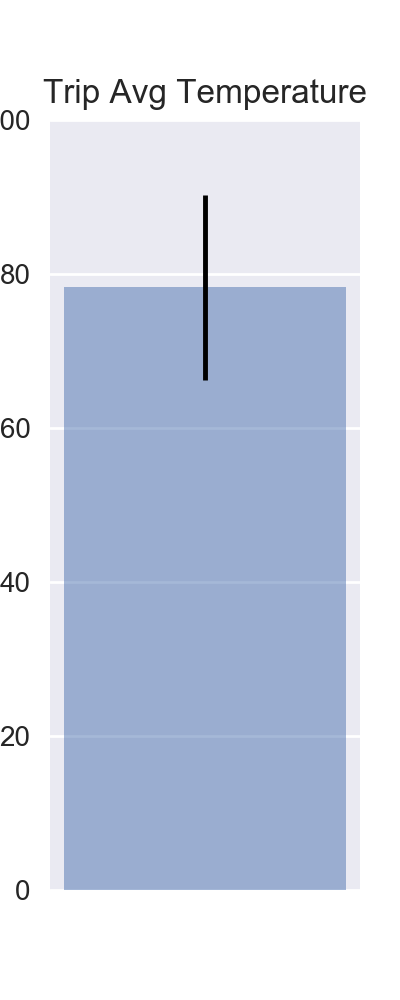

In [39]:
# Plot the min, avg, and max temperature from your previous query as a bar chart.

# Use the average temperature as the bar height.
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

# Plot Bar chart 
plt.figure(figsize=(2,5))
plt.bar(1,height=tavg, yerr=(tmax-tmin), width=0.0001, alpha=0.5)
plt.title("Trip Avg Temperature")
plt.xticks([])
plt.ylim(0,100)
plt.ylabel("Temp (F)")
plt.show()